In [1]:
"""
import modules
"""

from prepare_data import prepare_df_from_mac_5_year as prepare_CCL
from prepare_data import prepare_paths as prepare_paths
from emulate_reduction import emulator_v4 as emulate
from visualize_output import vis_emulator_v1 as v1_plot
from pym import pym

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import os

dir(prepare_paths)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'colors',
 'combine_azure_ctax',
 'np',
 'os',
 'output_costs_timer',
 'pd',
 'plot_MAC',
 'plt',
 'prepare_data',
 'pym',
 'truncate_colormap',
 'world_MAC_data']

In [2]:
"""
load data (cubic cubicroot linear and IAMC)
"""

PATH = 'C:/Users/toonv/Documents/PBL/Data/cost curves/'
PATH_IAMC = 'C:/Users/toonv/Documents/PBL/Data/IAMC_paths/'
PATH_IAMC_MYM = 'C:/Users/toonv/Documents/PBL/Data/IAMC_paths_mym/'
PATH_IAMC_CSV = 'C:/Users/toonv/Documents/PBL/Data/IAMC_paths_csv/'

FILENAME_LIN = 'costcurve_co2_linear.dat'
FILENAME_CUBIC = 'costcurve_co2_cubic.dat'
FILENAME_CUBICROOT = 'costcurve_co2_cubicroot.dat'
FILENAME_IAMC = 'iamc15_scenario_data_world_r2.0.xlsx'
FILENAME_MEAN_TEMP = 'mean_temp.csv'

df_linear = pd.read_table(PATH + FILENAME_LIN,
                          skiprows = [0,1,2], sep = ',', names = list(range(1,27)), index_col=False)

df_cubic = pd.read_table(PATH + FILENAME_CUBIC,
                          skiprows = [0,1,2], sep = ',', names = list(range(1,27)), index_col=False)

df_cubicroot = pd.read_table(PATH + FILENAME_CUBICROOT,
                          skiprows = [0,1,2], sep = ',', names = list(range(1,27)), index_col=False)

df_combined = pd.concat([df_linear, df_cubic, df_cubicroot])
df_cubic_cubicroot = pd.concat([df_cubic, df_cubicroot]) 

# new paths, from IAMC databese
IAMC_database = pd.read_excel(PATH_IAMC + FILENAME_IAMC, sheet_name='data')

In [3]:
"""
global variables 

year, region functie aanroepen waar je jaar en regio in kan vullen die alle stappen dan uitvoert.\\

dit zijn global constants dus kan gewoon in kleine letters

"""

year = 2060
region = 11
TIMERSTEP = 10
test_size = 0.2
stepsize_ctax_paths = 10
number_of_weights = 2

In [134]:
"""
load reductions calculated using the costcurvecooker

input: csv of all reductions (prepared using organize_azure_output.py)
        and definded ctax paths 
        
output: pandas dataframe with ctax paths and reductions until given year
"""

reload(prepare_paths)

# load reduction from azure output
emissions = pd.read_csv('C:/Users/toonv/Documents/PBL/Data/co2tax_total.csv')
years = [1971, 1981, 1991, 2001, 2011, 2021, 2031, 2041, 2051, 2061, 2071, 2081, 2091, 2100]
columns = ['ctax_index', 'region'] + years  # dont know how to set headers for multi-index
emissions.columns = columns

baseline = emissions.loc[emissions.ctax_index == 0]

# load ctax paths csv
ctax_paths = pd.read_excel('C:/Users/toonv/Documents/PBL/Data/IAMC_paths/all_ctax_paths.xlsx', index_col=[0])
ctax_paths.index.name = 'ctax_index'

# functie met jaar en regio geeft dataframe met paths en reducties (%)
data_for_emulator = prepare_paths.combine_azure_ctax(year, region, ctax_paths, emissions, baseline)

# prepare_paths.plot_MAC(data_for_emulator)

data_for_emulator.tail()

    ctax_index  region          1971          1981          1991  \
0            0       0  8.969030e+10  1.117960e+11  1.169163e+11   
1            0       1  1.110139e+12  1.245669e+12  1.299780e+12   
2            0       2  3.019588e+10  6.728479e+10  8.076364e+10   
3            0       3  2.121353e+10  2.690361e+10  2.661901e+10   
4            0       4  2.441268e+10  5.178711e+10  6.683297e+10   
5            0       5  7.215944e+10  9.123639e+10  9.905334e+10   
6            0       6  2.308043e+10  4.499179e+10  6.332843e+10   
7            0       7  1.605626e+10  3.262153e+10  2.805236e+10   
8            0       8  3.909969e+09  4.755649e+09  5.721862e+09   
9            0       9  4.410717e+10  6.424712e+10  8.084282e+10   
10           0      10  9.013437e+11  9.410540e+11  9.588301e+11   
11           0      11  2.128582e+11  2.947414e+11  2.700985e+11   
12           0      12  1.102718e+10  1.886363e+10  3.509042e+10   
13           0      13  1.549856e+11  1.930306e+

,2020,2030,2040,2050,2060,reduction
1261,0.0,2519.842100,3174.802104,3634.241186,4000.000000,91.941200
1262,0.0,2339.214191,2947.225199,3373.730661,3713.271067,92.955423
1263,0.0,2201.284833,2773.445097,3174.802104,3494.321859,91.556817
1264,0.0,2091.031834,2634.535024,3015.789765,3319.306133,92.568007
1265,0.0,2000.000000,2519.842100,2884.499141,3174.802104,91.419906


In [67]:
"""
prepare data using prepare_df

input: MAC sets (df)

output: ctax paths with reduction
"""
reload(prepare_CCL)

lin_reduction = prepare_CCL.reduction_df(df_linear, year, region)
cubic_reduction = prepare_CCL.reduction_df(df_cubic, year, region)
root_reduction = prepare_CCL.reduction_df(df_cubicroot, year, region)

lin_paths = prepare_CCL.find_path(lin_reduction, 'linear', TIMERSTEP)
cubic_paths = prepare_CCL.find_path(cubic_reduction, 'cubic', TIMERSTEP)
root_paths = prepare_CCL.find_path(root_reduction, 'cubicroot', TIMERSTEP)

combi = pd.concat([cubic_paths, root_paths])
combi.year = cubic_paths.year
combi.region = cubic_paths.region

print(combi.year)

combi.tail()

2060


,2020,2030,2040,2050,2060,reduction
196,0.0,2469.445258,3111.306062,3561.556362,3920.0,95.4218
197,0.0,2482.044468,3127.180072,3579.727568,3940.0,95.4228
198,0.0,2494.643679,3143.054083,3597.898774,3960.0,95.4238
199,0.0,2507.242889,3158.928093,3616.069980,3980.0,95.4248
200,0.0,2519.842100,3174.802104,3634.241186,4000.0,95.4258


In [76]:
"""
train prepared dataframe 

input: ctax paths with reduction

output: trained dataset
"""

reload(emulate)

# x = emulate.CtaxRedEmulator(lin_paths, combi, test_size)

x = emulate.CtaxRedEmulator(data_for_emulator[0:101], data_for_emulator, test_size)

x.train_ctax_path(stepsize_ctax_paths, number_of_weights)   
    
x.test_ctax_paths() 


0
37
37
37
10


C:\Users\toonv\Documents\PBL\Code\Emulator\emulate_reduction\emulator_v4.py:81: RuntimeWarning: divide by zero encountered in true_divide
  delta_c_norm = delta_cs / final_ctax[:, None]
C:\Users\toonv\Documents\PBL\Code\Emulator\emulate_reduction\emulator_v4.py:81: RuntimeWarning: invalid value encountered in true_divide
  delta_c_norm = delta_cs / final_ctax[:, None]
C:\Users\toonv\Anaconda3\lib\site-packages\numpy\core\_methods.py:160: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
C:\Users\toonv\Anaconda3\lib\site-packages\numpy\core\_methods.py:160: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


IndexError: index 63 is out of bounds for axis 0 with size 63

method:  multivariate linear regression 
 RMSE:  17.054616634003697 
 R-squared:  0.5306580116107416


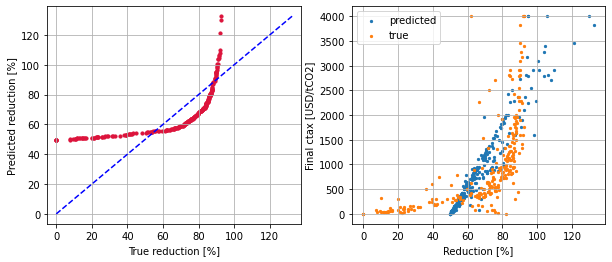

In [180]:
reload(emulate)

x = emulate.CtaxRedEmulator(lin_paths, data_for_emulator, test_size)

# multi linear regression model
multi_lin_regr_mod = x.train_ctax_MLR()
multi_lin_plot = x.test_regr(multi_lin_regr_mod)
x.scatter_and_mac(multi_lin_regr_mod)

# polynomial regression model
# degree = 3
# poly_regr_mod = x.train_ctax_PR(degree)
# poly_regr_plot = x.test_regr(poly_regr_mod)

# # Ridge regression
# alpha = 1
# ridge_mod = x.train_ctax_ridge(alpha)
# ridge_plot = x.test_regr(ridge_mod)

# # lasso regression
# alpha = 1
# lasso_mod = x.train_ctax_lasso(alpha)
# lasso_plot = x.test_regr(lasso_mod)

# Regression tree
# max_depth = 5
# regr_tree = x.train_ctax_tree(max_depth)
# tree_plot = x.test_regr(regr_tree)

# Random forest
# regr_forest = x.train_ctax_forest(max_depth)
# forest_plot = x.test_regr(regr_forest)

# SVM
# svm_regr = x.train_SVM()
# svm_plot = x.test_regr(svm_regr)
# x.scatter_and_mac(svm_regr)

# # MLPRegressor
# MLP_regr = x.train_MLPRegressor()
# MLP_plot = x.test_regr(MLP_regr)

# TensorFlow
# TF_regr = x.train_TF()


costs :  703589701.2324039


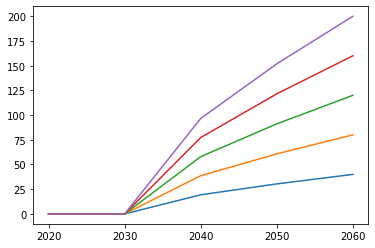

In [181]:
"""
calculate miti costs
"""
reload(emulate)

emu_method = 'SVM'
step_ctax = 40
x.calc_miti_costs(emu_method, region, step_ctax, emissions, baseline, data_for_emulator)

